In [3]:
%pip install numpy pyscipopt matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from pyscipopt import Model, quicksum

In [5]:
plt.style.use('bmh')

In [7]:
def optimize(
    position: npt.NDArray[np.int64],
    ideal_ratios: npt.NDArray[np.float64],
    positive_amount: int,
    negative_amount: int,
    min_piece: int,
    min_increment: int,
):
    model = Model()
    # model.setParam("limits/time", 60)
    # model.setParam("numerics/feastol", 1e-7)

    scaled_positive_amount = positive_amount // min_increment
    scaled_negative_amount = negative_amount // min_increment
    scaled_position = position // min_increment
    scaled_min_piece = min_piece // min_increment

    num_funds = len(scaled_position)
    new_total_amount = scaled_position.sum() + scaled_positive_amount + scaled_negative_amount

    trades_positive = model.addMatrixVar(
        num_funds,
        name="trade_amounts_positive",
        ub=scaled_positive_amount,
        lb=0,
        vtype="I",
    )

    trades_negative = model.addMatrixVar(
        num_funds,
        name="trade_amounts_negative",
        ub=0,
        lb=scaled_negative_amount,
        vtype="I",
    )

    final_position = model.addMatrixVar(
        num_funds,
        name="final_position",
        lb=None,
        vtype="I",
    )

    model.addCons(trades_positive.sum() == scaled_positive_amount)
    model.addCons(trades_negative.sum() == scaled_negative_amount)

    model.addCons(final_position.sum() == new_total_amount)

    model.addMatrixCons(final_position == scaled_position + trades_positive + trades_negative)

    min_piece_valid = model.addMatrixVar(
        num_funds,
        name="min_piece",
        vtype="B",
    )

    is_positive_dir = model.addMatrixVar(
        num_funds,
        name="is_positive_dir",
        vtype="B",
    )

    # Essa seguinte parte serve para modelar restrições do tipo OU usando restrições lineares
    # -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    big_m = np.maximum(
        abs(scaled_position + scaled_positive_amount),
        abs(scaled_position + scaled_negative_amount),
    ) + scaled_min_piece

    # Se min_piece_valid = 0, então final_position = 0
    model.addMatrixCons(is_positive_dir <= min_piece_valid)

    # Se min_piece_valid = 1, então |final_position| <= big_m que é igual a -big_m <= final_position <= big_m
    model.addMatrixCons(final_position <= big_m * min_piece_valid)
    model.addMatrixCons(final_position >= -big_m * min_piece_valid)

    # Se min_piece_valid = 1 e is_positive_dir = 1, então final_position >= scaled_min_piece
    model.addMatrixCons(final_position >= scaled_min_piece * min_piece_valid - big_m * (1 - is_positive_dir))

    # Se min_piece_valid = 1 e is_positive_dir = 0, então final_position <= -scaled_min_piece
    model.addMatrixCons(final_position <= -scaled_min_piece * min_piece_valid + big_m * is_positive_dir + big_m * (1 - min_piece_valid))

    # -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

    new_ratios = model.addMatrixVar(
        num_funds,
        name="new_ratios",
        lb=0,
        vtype="C",
    )

    model.addMatrixCons(new_total_amount * new_ratios == final_position)

    ratios_errors = model.addMatrixVar(
        num_funds,
        name="ratios_errors",
        lb=0,
        vtype="C",
    )

    z = model.addVar(name="z", vtype="C")

    model.addMatrixCons(ideal_ratios * ratios_errors >= new_ratios - ideal_ratios)
    model.addMatrixCons(ideal_ratios * ratios_errors >= -(new_ratios - ideal_ratios))
    # model.addMatrixCons(ideal_ratios ** 2 * ratios_errors == (new_ratios - ideal_ratios) ** 2)

    expr = quicksum(
        ratios_errors[fund]
        for fund in range(num_funds)
    )

    scale_factor = 10000
    
    model.addCons(z >= expr * scale_factor)

    model.setObjective(z, "minimize")

    model.optimize()
    
    status = model.getStatus()
    print(f"Status: {status}")
    
    if status == "infeasible":
        print("\nPROBLEMA INFEASÍVEL!")
        print("\nAnalisando conflito...")
        model.writeProblem("debug_model.lp")
        print("Modelo salvo em: debug_model.lp")
        return None, None
    

    return model.getVal(trades_positive) * min_increment, model.getVal(trades_negative) * min_increment

In [ ]:
position = np.array([9902, 89787, 20, 14008, 1689, 38, 53556], dtype=np.int64)
positive_amount = 100000
negative_amount = -100000
ideal_ratios = np.array([0.2523677372486256, 0.17010906099149858, 0.053109950549653805, 0.379392770883289, 0.09772944240523304, 0.01592742600174438, 0.031363611919955785], dtype=np.float64)
min_piece = 1
min_increment = 1


trades_positive, trades_negative = optimize(position, ideal_ratios, positive_amount, negative_amount, min_piece, min_increment)
if trades_positive is None or trades_negative is None:
    print("Erro ao otimizar")
    exit()

print(trades_positive)
print(trades_negative)

# trades_positive = np.array([29963, 0, 8194, 45848, 13567, 2428, 0])
# trades_negative = np.array([0, -55848, 0, 0, 0, 0, -44152])
new_position = position + trades_positive + trades_negative
new_ratios = new_position / new_position.sum()
print('initial_ratios: ', position / position.sum())
print('new_ratios: ', new_ratios)
print('ideal_ratios: ', ideal_ratios)
print('ideal_position: ', ideal_ratios * new_position.sum())
print('final_position: ', new_position)
diff = new_ratios - ideal_ratios
diff_relativo = diff / ideal_ratios
diff_sqr = diff ** 2
diff_relativo_sqr = diff_relativo ** 2
print('diff: ', diff)
print('diff_relativo: ', diff_relativo)
print('Error: ', np.sqrt(diff_sqr.sum()/len(ideal_ratios)))
print('Error relativo: ', np.sqrt(diff_relativo_sqr.sum()/len(ideal_ratios)))

Status: optimal
[32748.     0.  8956. 40815. 14827.  2654.     0.]
[     0. -51745.      0.      0.      0.      0. -48255.]
initial_ratios:  [5.85917160e-02 5.31284024e-01 1.18343195e-04 8.28875740e-02
 9.99408284e-03 2.24852071e-04 3.16899408e-01]
new_ratios:  [0.23588757 0.20082249 0.04860355 0.35417751 0.09027219 0.01459172
 0.05564497]
ideal_ratios:  [0.25236774 0.17010906 0.05310995 0.37939277 0.09772944 0.01592743
 0.03136361]
ideal_position:  [42650.14759502 28748.43130756  8975.58164289 64117.37827928
 16516.27576648  2691.73499429  5300.45041447]
final_position:  [39865 33939  8214 59856 15256  2466  9404]
diff:  [-0.01648016  0.03071342 -0.0045064  -0.02521526 -0.00745725 -0.00133571
  0.02428136]
diff_relativo:  [-0.06530218  0.18055137 -0.08485039 -0.06646214 -0.07630508 -0.08386227
  0.77418885]
Error:  0.018966158232160624
Error relativo:  0.3072234391783343


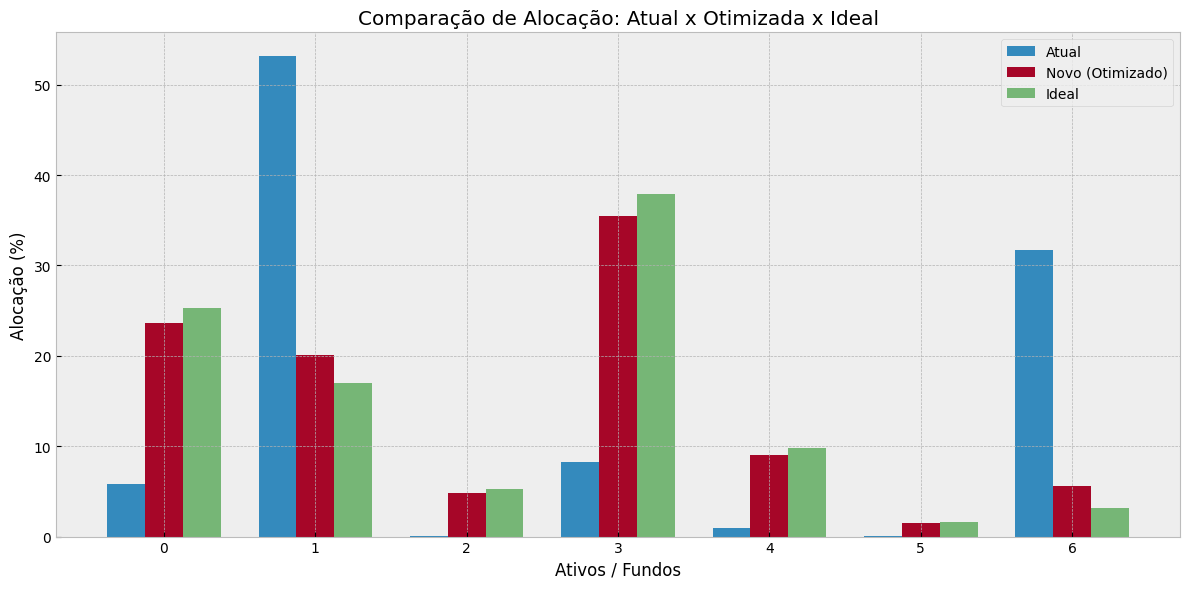

In [15]:
indices = np.arange(len(position))
width = 0.25

initial_ratios_plot = position / position.sum()

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(indices - width, initial_ratios_plot * 100, width, label='Atual')
rects2 = ax.bar(indices, new_ratios * 100, width, label='Novo (Otimizado)')
rects3 = ax.bar(indices + width, ideal_ratios * 100, width, label='Ideal', alpha=0.5, color='green')

ax.set_ylabel('Alocação (%)')
ax.set_xlabel('Ativos / Fundos')
ax.set_title('Comparação de Alocação: Atual x Otimizada x Ideal')
ax.set_xticks(indices)
ax.legend()

plt.tight_layout()
plt.show()

In [19]:
position = np.array([150, 100], dtype=np.int64)
ideal_ratios = np.array([0.6, 0.4], dtype=np.float64)
positive_amount = 0
negative_amount = -100
min_piece = 100
min_increment = 50

trades_positive, trades_negative = optimize(position, ideal_ratios, positive_amount, negative_amount, min_piece, min_increment)
if trades_positive is None or trades_negative is None:
    print("Erro ao otimizar")
    exit()

print(trades_positive)
print(trades_negative)

# trades_positive = np.array([0, 0])
# trades_negative = np.array([-60, -40])
new_position = position + trades_positive + trades_negative
new_ratios = new_position / new_position.sum()
print('initial_ratios: ', position / position.sum())
print('new_ratios: ', new_ratios)
print('ideal_ratios: ', ideal_ratios)
print('ideal_position: ', ideal_ratios * new_position.sum())
print('final_position: ', new_position)
diff = new_ratios - ideal_ratios
diff_relativo = diff / ideal_ratios
diff_sqr = diff ** 2
diff_relativo_sqr = diff_relativo ** 2
print('diff: ', diff)
print('diff_relativo: ', diff_relativo)
print('Error: ', np.sqrt(diff_sqr.sum()/len(ideal_ratios)))
print('Error relativo: ', np.sqrt(diff_relativo_sqr.sum()/len(ideal_ratios)))

Status: optimal
[-0. -0.]
[   0. -100.]
initial_ratios:  [0.6 0.4]
new_ratios:  [1. 0.]
ideal_ratios:  [0.6 0.4]
ideal_position:  [90. 60.]
final_position:  [150.   0.]
diff:  [ 0.4 -0.4]
diff_relativo:  [ 0.66666667 -1.        ]
Error:  0.4
Error relativo:  0.8498365855987975
